In [475]:
from helpers import *
import pandas as pd
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import seaborn as sns
import matplotlib.pyplot as plt
import random
import warnings 
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

# imports
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# ignore warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# auto reloading library (mainly for altering helpers.py)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [476]:
pd.set_option('display.max_columns', None)

In [477]:
training_filters = [
    {
        'feature': 'month',
        'operator': 'between',
        'value': [3, 9]
    },
]

validation_filters = [
    {
        'feature': 'date_forecast',
        'operator': 'between',
        'value': ['2020-05-01', '2020-07-01']
    }
]

test_filters = [
    {
        'feature': 'date_forecast',
        'operator': 'between',
        'value': ['2021-05-01', '2021-07-01']
    }
]

In [478]:
agg_strats = ['min','max']
#agg_strats = ['mean']


m_wrap = DataWrapper(
    impute_strategy = 'fbfill',
    aggregation_strats = agg_strats,
    y_scalers = [Y_Scaler_MaxAbs_per_building()],
    transform_pred_strategy = ['clip','sun_el_thr'],
    training_filters=training_filters,
    validation_filters=validation_filters,
    test_filters=test_filters,
    bagging_filters=False, # these are applied additionally to the other filters on val, test, sub
    )

{'a': 5733.42, 'b': 1152.3, 'c': 999.6}
{'a': 5733.42, 'b': 1152.3, 'c': 999.6}


In [479]:
# get data
# X_train, y_train = m_wrap.get_train(aggregated=False,drop_val=True,drop_test=False)
# X_val, y_val = m_wrap.get_val(aggregated=False)
# X_test, y_test = m_wrap.get_test(aggregated=False)
# X_sub = m_wrap.get_sub(aggregated=False)
# X_test, y_test = m_wrap.get_test(aggregated=False)


X_train_agg, y_train_agg = m_wrap.get_train(aggregated=True,drop_val=False,drop_test=True,y_scaled=True)
#X_val_agg, y_val_agg = m_wrap.get_val(aggregated=True)
X_test_agg, y_test_agg = m_wrap.get_test(aggregated=True,y_scaled=False)
X_sub_agg = m_wrap.get_sub(aggregated=True)

In [480]:
val_idx = X_train_agg['date_forecast'].between('2020-05-01', '2020-07-01')-1
ps = PredefinedSplit(test_fold=val_idx)

In [481]:
# exclude datetime columns
X_train_agg = X_train_agg.select_dtypes(exclude=['datetime','timedelta','period[M]'])
#X_val_agg = X_val_agg.select_dtypes(exclude=['datetime','timedelta','period[M]'])

# automatically set types of columns for imputing and oneHotEncoding
categorical_features = X_train_agg.select_dtypes(include=['object']).columns.tolist()
impute_features = X_train_agg.loc[:, X_train_agg.isna().any()].columns.tolist()

print(f"categorical_features: {categorical_features}")
print(f"impute_features: {impute_features}")


columnTransformer = ColumnTransformer(
    transformers=[
        ('imputer', SimpleImputer(strategy='constant'),impute_features),
        ('oneHotEncoder', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ],
    remainder='passthrough',  # Dont drop remaining columns
    n_jobs=-1
)

mod = XGBRegressor(
    # reg_lambda=10,
    # reg_alpha=10,
    min_child_weight=5,
    learning_rate=0.03,
    max_depth=9,
    n_estimators=300,
    objective='reg:absoluteerror',
)

mod = CatBoostRegressor(
    objective='MAE',
    iterations=800,
    depth=8,
    random_seed=42,
)

mod = LGBMRegressor(
    random_state=42,
    objective='mae',
    n_estimators=300,
    learning_rate=0.07,
    max_depth=-1,
    # n_jobs=-1,
    # bagging_fraction=0.8,
    # bagging_freq=1,
    # feature_fraction=0.8,

)

open('status.csv', 'w').close()
# build the pipeline
mod_pipe = Pipeline(steps=[
    ('columnTransformer', columnTransformer),
    ('statusSaver', StatusSaver()),
    ('estimator', mod)
])

categorical_features: ['building_id']
impute_features: ['delta_forecast', 'min_ceiling_height_agl:m', 'min_cloud_base_agl:m', 'min_snow_density:kgm3', 'min_effective_cloud_cover_5h_mean', 'min_GHI_lag_-1h', 'min_GHI_lag_1h', 'min_temp*GHI_lag_-1h', 'min_temp*GHI_lag_1h', 'min_effective_cloud_cover:p_-1h', 'min_effective_cloud_cover:p_1h', 'min_cloud_base_agl:m_-1h', 'min_cloud_base_agl:m_1h', 'max_ceiling_height_agl:m', 'max_cloud_base_agl:m', 'max_snow_density:kgm3', 'max_effective_cloud_cover_5h_mean', 'max_GHI_lag_-1h', 'max_GHI_lag_1h', 'max_temp*GHI_lag_-1h', 'max_temp*GHI_lag_1h', 'max_effective_cloud_cover:p_-1h', 'max_effective_cloud_cover:p_1h', 'max_cloud_base_agl:m_-1h', 'max_cloud_base_agl:m_1h']


In [482]:
def std_per_sample(y, y_pred):
    return np.std((y - y_pred), axis=0)

std_scorer = make_scorer(std_per_sample, greater_is_better=False)

scoring = {
    'MAE': 'neg_mean_absolute_error',
    'STD': std_scorer
}

In [483]:
# run grid search
# gs = GridSearchCV(
#     mod_pipe,
#     param_grid={
#         'estimator__verbose': [1],
#         # 'estimator__learning_rate': np.arange(0.1, 0.001, -0.010),
#         # 'estimator__max_depth': np.arange(13, 1, -1)
#         # 'estimator__n_estimators': np.arange(500,100,-50),
#         # 'estimator__colsample_bytree': np.arange(0.0,1.0001,0.025),
#         # 'estimator__reg_alpha': np.arange(0, 15, 1)
#         # 'estimator__reg_lambda': np.arange(0, 30, 1),
#         # 'estimator__min_child_weight': np.arange(0,10,1),
#         # 'estimator__l2_leaf_reg': [0, 1, 3, 6, 10],
#         # 'estimator__depth' : [5,6,7,8],
#         # 'estimator__iterations': [800, 1000, 1200],

#     },
#     cv=ps,
#     n_jobs=-1,
#     scoring=scoring,
#     verbose=2,
#     refit='MAE'
# )

gs = GridSearchCV(
    mod_pipe,
    param_grid={
        'estimator__verbose': [1],
        # 'estimator__objective':['mae','rmse'],
        # 'estimator__n_estimators': np.arange(50,300,25),
        # 'estimator__learning_rate':[0.2,0.1,0.07,0.05,0.03,0.01,0.005,0.001],
        # 'estimator__max_depth':[-1]+list(np.arange(13,3,-1)),
        # 'estimator__bagging_fraction':np.arange(0.1,1.0001,0.025),
        # 'estimator__bagging_freq':np.arange(1,10,1),
        # 'estimator__feature_fraction':np.arange(0.1,1.0001,0.025),
    },
    cv=ps,
    n_jobs=-1,
    scoring=scoring,
    verbose=2,
    refit='MAE'
)

# bs = BayesSearchCV(
#     mod_pipe,
#     search_spaces={
#         'estimator__learning_rate': Real(0.05, 0.3),
#         'estimator__max_depth': Integer(3, 13),
#         'estimator__n_estimators': Integer(20,500),
#         'estimator__colsample_bytree': Real(0.001,1),
#         'estimator__reg_alpha': Real(0, 50),
#         'estimator__reg_lambda': Real(0, 50),
#         'estimator__min_child_weight': Real(0,50)
#     },
#     cv=ps,
#     n_jobs=-1,
#     scoring='neg_mean_absolute_error',
#     verbose=2,
#     n_iter=150,
#     n_points=6,
#     return_train_score=True
# )

gs.fit(X_train_agg, y_train_agg)


Fitting 1 folds for each of 1 candidates, totalling 1 fits
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010864 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 22482
[LightGBM] [Info] Number of data points in the train set: 37104, number of used features: 135
[LightGBM] [Info] Start training from score 0.032254
[CV] END ...............................estimator__verbose=1; total time=   2.5s
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006272 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 22494
[LightGBM] [Info] Number of data points in the train set: 41425, number of used features: 135
[LightGBM] [Info] Start training from score 0.039216


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ..., -1, -1])),
             estimator=Pipeline(steps=[('columnTransformer',
                                        ColumnTransformer(n_jobs=-1,
                                                          remainder='passthrough',
                                                          transformers=[('imputer',
                                                                         SimpleImputer(strategy='constant'),
                                                                         ['delta_forecast',
                                                                          'min_ceiling_height_agl:m',
                                                                          'min_cloud_base_agl:m',
                                                                          'min_snow_density:kgm3',
                                                                          'min_effective_cloud_cover_5h_m...
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['building_id'])])),
                                       ('statusSaver', StatusSaver()),
                                       ('estimator',
                                        LGBMRegressor(learning_rate=0.07,
                                                      n_estimators=300,
                                                      objective='mae',
                                                      random_state=42))]),
             n_jobs=-1, param_grid={'estimator__verbose': [1]}, refit='MAE',
             scoring={'MAE': 'neg_mean_absolute_error',
                      'STD': make_scorer(std_per_sample, greater_is_better=False)},
             verbose=2)

In [484]:
print(gs.best_params_)

{'estimator__verbose': 1}


In [485]:
model = gs.best_estimator_

In [486]:
# get val scores
# sns.lineplot(gs.cv_results_['mean_test_score'])

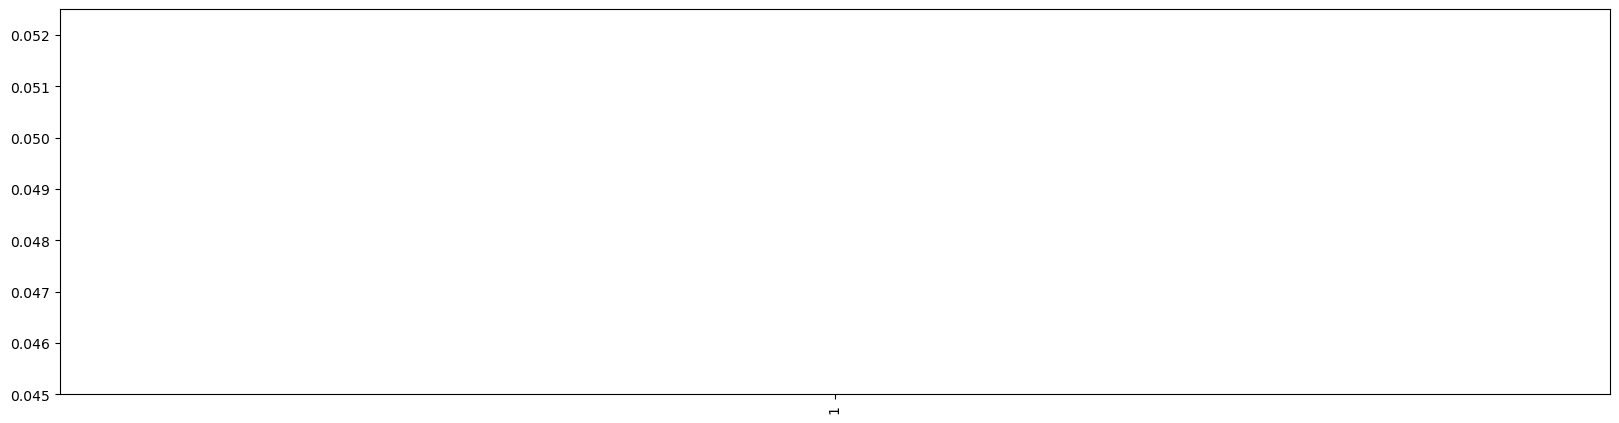

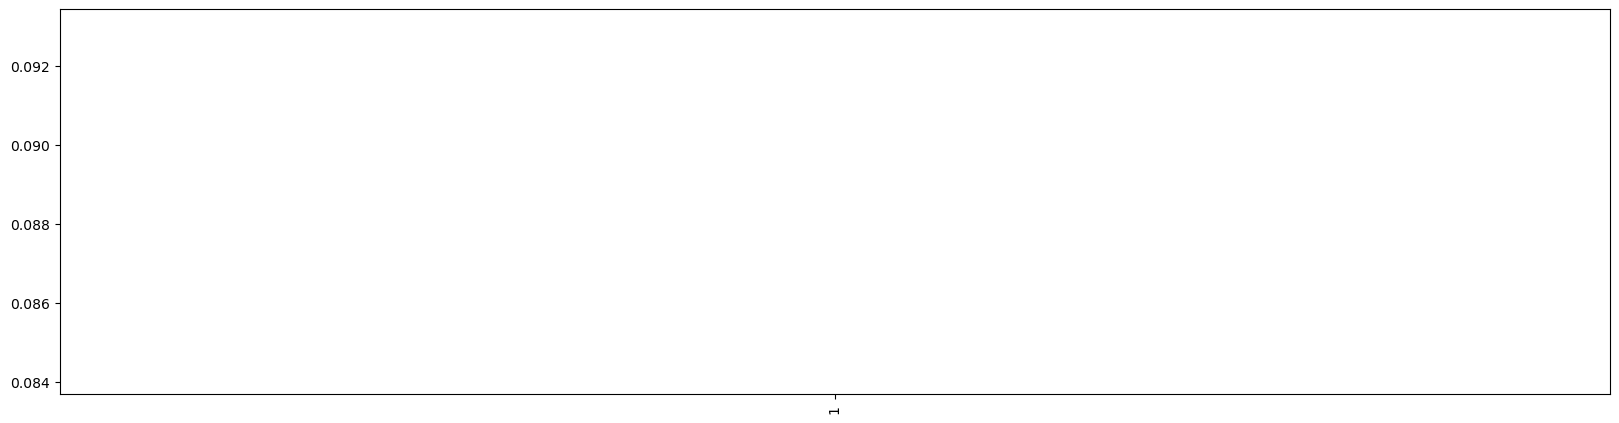

In [487]:
for key, values in gs.param_grid.items():
    pass

plt.figure(figsize=(20, 5))
plt.ylim(0.045, 0.0525)
sns.lineplot(y=gs.cv_results_['mean_test_MAE']*-1, x=list(map(str, values)))
plt.xticks(rotation=90);

plt.figure(figsize=(20, 5))
sns.lineplot(y=gs.cv_results_['mean_test_STD']*-1, x=list(map(str, values)))
plt.xticks(rotation=90);

In [488]:
pred = pd.Series(model.predict(X_test_agg))

In [489]:
mae = m_wrap.get_mae(pred,X_test_agg, y_test_agg, is_aggregated=True)
print(f'MAE: {mae}')

MAE: 143.1730332502586


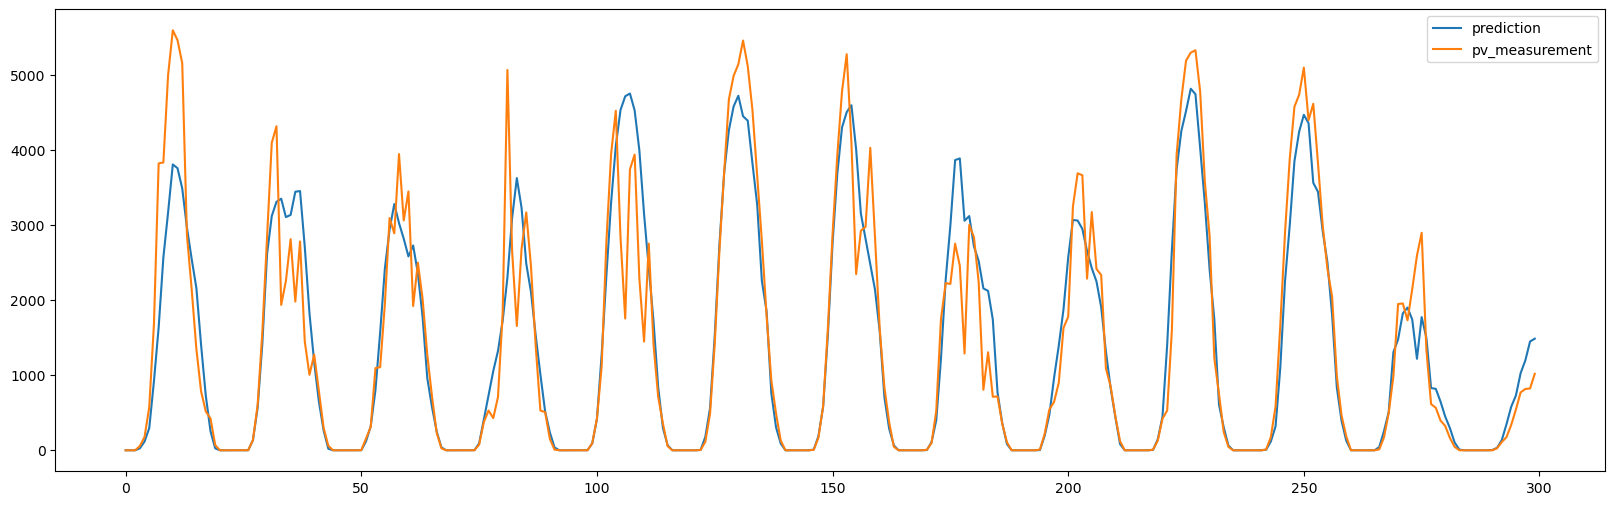

In [490]:
m_wrap.plot_Pred_vs_PV(pred,y_test_agg,X_test_agg,start_idx=0,end_idx=300)

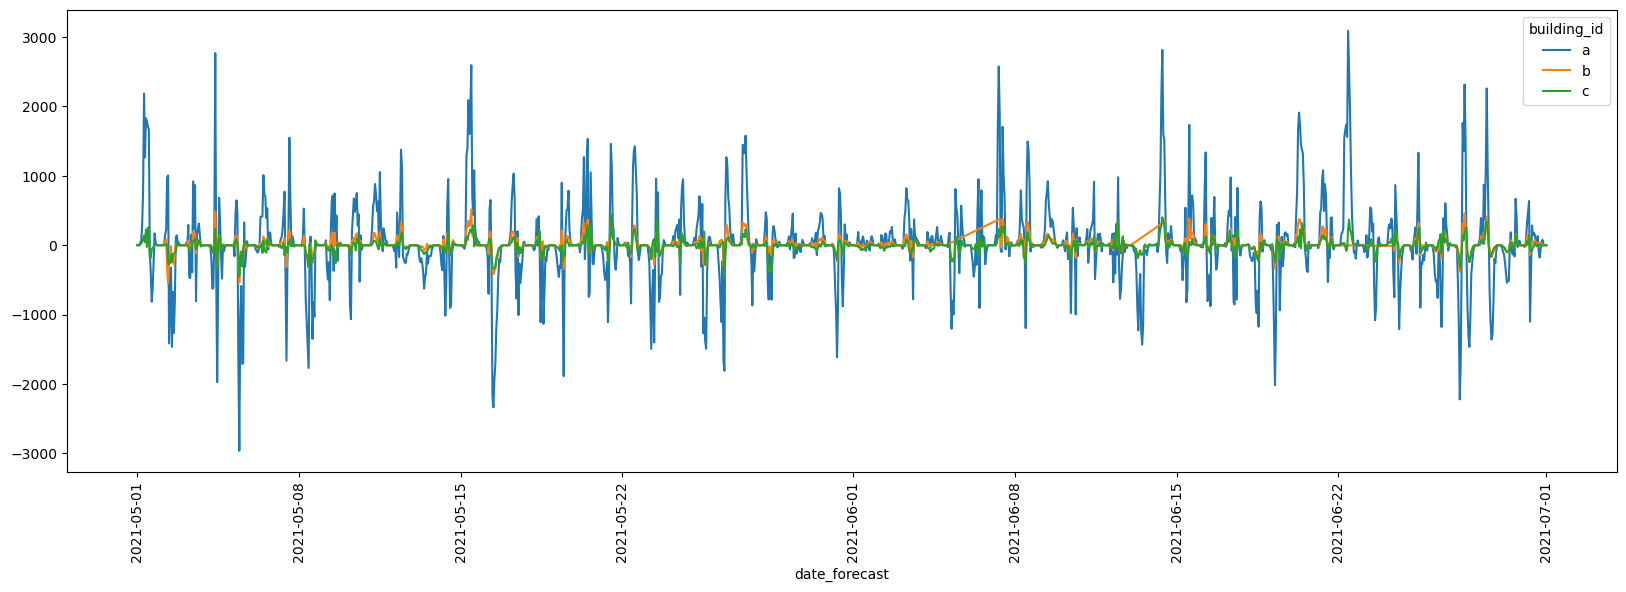

In [491]:
m_wrap.plot_Residuals(pred,y_test_agg,X_test_agg)

In [492]:
model

Pipeline(steps=[('columnTransformer',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('imputer',
                                                  SimpleImputer(strategy='constant'),
                                                  ['delta_forecast',
                                                   'min_ceiling_height_agl:m',
                                                   'min_cloud_base_agl:m',
                                                   'min_snow_density:kgm3',
                                                   'min_effective_cloud_cover_5h_mean',
                                                   'min_GHI_lag_-1h',
                                                   'min_GHI_lag_1h',
                                                   'min_temp*GHI_lag_-1h',
                                                   'min_temp*GHI_l...
                                                   'max_temp*GHI_lag_1h',
                                                   'max_effective_cloud_cover:p_-1h',
                                                   'max_effective_cloud_cover:p_1h',
                                                   'max_cloud_base_agl:m_-1h',
                                                   'max_cloud_base_agl:m_1h']),
                                                 ('oneHotEncoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['building_id'])])),
                ('statusSaver', StatusSaver()),
                ('estimator',
                 LGBMRegressor(learning_rate=0.07, n_estimators=300,
                               objective='mae', random_state=42, verbose=1))])

In [493]:
X_all, y_all = m_wrap.get_train(aggregated=True,drop_val=False,drop_test=False,y_scaled=True)
X_all = X_all.select_dtypes(exclude=['datetime','timedelta','period[M]'])

model.fit(X_all, y_all)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005507 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 22504
[LightGBM] [Info] Number of data points in the train set: 45654, number of used features: 135
[LightGBM] [Info] Start training from score 0.046407


Pipeline(steps=[('columnTransformer',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('imputer',
                                                  SimpleImputer(strategy='constant'),
                                                  ['delta_forecast',
                                                   'min_ceiling_height_agl:m',
                                                   'min_cloud_base_agl:m',
                                                   'min_snow_density:kgm3',
                                                   'min_effective_cloud_cover_5h_mean',
                                                   'min_GHI_lag_-1h',
                                                   'min_GHI_lag_1h',
                                                   'min_temp*GHI_lag_-1h',
                                                   'min_temp*GHI_l...
                                                   'max_temp*GHI_lag_1h',
                                                   'max_effective_cloud_cover:p_-1h',
                                                   'max_effective_cloud_cover:p_1h',
                                                   'max_cloud_base_agl:m_-1h',
                                                   'max_cloud_base_agl:m_1h']),
                                                 ('oneHotEncoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['building_id'])])),
                ('statusSaver', StatusSaver()),
                ('estimator',
                 LGBMRegressor(learning_rate=0.07, n_estimators=300,
                               objective='mae', random_state=42, verbose=1))])

In [496]:
pred_sub = pd.Series(model.predict(X_sub_agg))
m_wrap.y_pred_to_csv(pred_sub, X_sub_agg, is_aggregated=True,name='lightGBM_MinMax_300.csv',sun_el_thr=1)

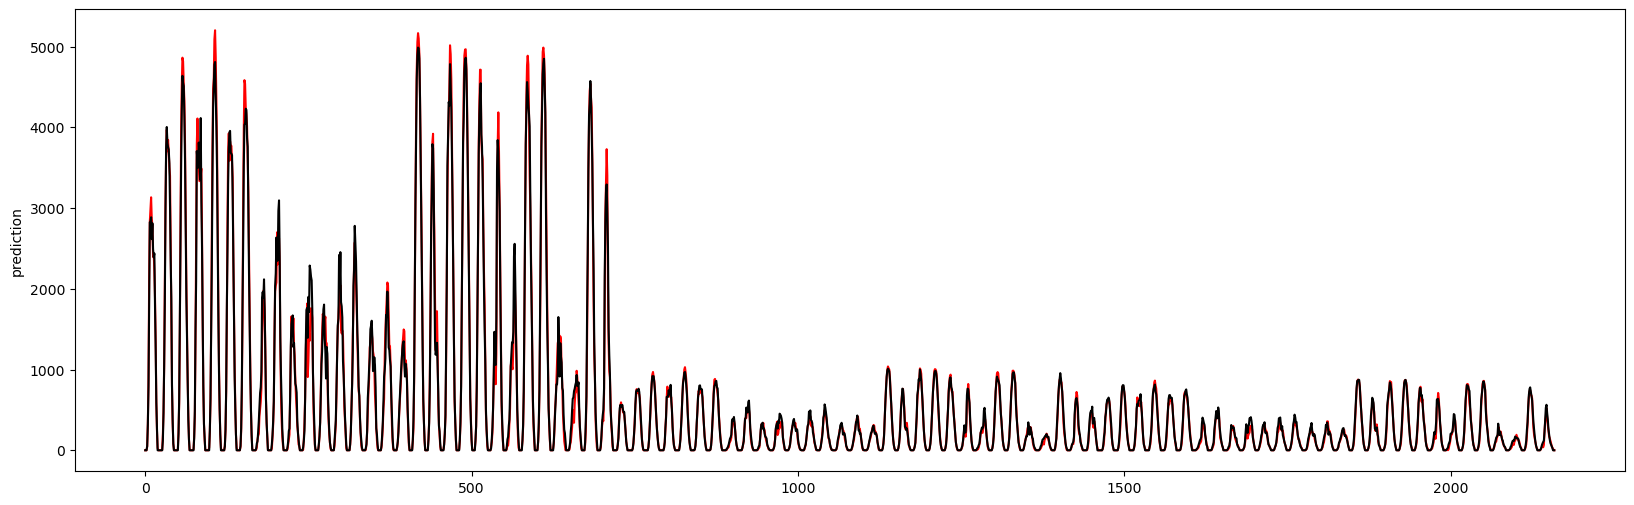

In [495]:
m_wrap.plot_yPredSub_vs_submission(pred_sub,X_sub_agg,sub_file='./submission_files/152_029_xgboost.csv')